# Decomposer Test

This notebook is made for assessing the performence of the decomposer alone

## Generate QD

In [1]:
from transformers.models.auto.tokenization_auto import AutoTokenizer
from peft import AutoPeftModelForCausalLM
from datasets import load_dataset
from tqdm import tqdm

from src.processors import ProcessorRegistry
from src.utils.generation import to_model_prompt, generate_batch
from src.inference.qpl.text_to_qpl import get_decomposer_generation_params, DecomposerMode
import src.utils.paths as p

# Constants
BATCH_SIZE = 8
MAX_NEW_TOKENS = 8192
MODEL_DIR = "jaqv74z8_Qwen3-4B-qpl-decomposer-cot-ds_train_batch_size=1_gradient_accumulation_steps=8_learning_rate=0.0002_num_train_epochs=4_gradient_checkpointing=True_logging_steps=0.00125_save_steps=0.0625_random_seed=1_lora=True_r=16_alpha=32_dropout=0.05"
MODEL_CKPT = MODEL_DIR + "/checkpoint-2712"
MODEL_PATH = p.TRAINED_MODELS_DIR / MODEL_CKPT
# DATASET_ID = "bgunlp/question_decomposer_ds"
DATASET_ID = "d4nieldev/qpl-decomposer-cot-ds"
MAX_RETRIES = 3
MODE = DecomposerMode.SAMPLING


# Load model & tokenizer
model = AutoPeftModelForCausalLM.from_pretrained(MODEL_PATH).cuda()
model = model.eval()
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Load and process data
test_dataset = list(load_dataset(DATASET_ID, split="validation"))
processor = ProcessorRegistry.get(DATASET_ID)(with_assistant=False)
chat_templates = list(map(processor.to_chat_template, test_dataset))
prompts = list(map(lambda ct: to_model_prompt(tokenizer, ct), chat_templates))

# Decompose questions
predictions = generate_batch(
    model=model,
    tokenizer=tokenizer,
    model_prompts=prompts,
    batch_size=BATCH_SIZE,
    max_new_tokens=MAX_NEW_TOKENS,
    progress_bar=tqdm(total=len(prompts), desc="Decomposing"),
    max_retries=MAX_RETRIES,
    **get_decomposer_generation_params(MODE)
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Decomposing: 100%|██████████| 3043/3043 [2:57:37<00:00,  3.50s/it]  


## Evaluate

[2025-07-15 03:59:55] INFO - sentence_transformers.SentenceTransformer - Use pytorch device_name: cuda:0
[2025-07-15 03:59:55] INFO - sentence_transformers.SentenceTransformer - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
[2025-07-15 04:00:01] WARNING - root - No valid parent found for question: Find the id and country of all tv channels.
[2025-07-15 04:00:01] WARNING - root - No valid parent found for question: Find the different countries and the number of tv channels from each.
[2025-07-15 04:00:01] WARNING - root - No valid parent found for question: Find the countries where have more than two tv channels.
[2025-07-15 04:00:01] WARNING - root - No valid parent found for question: find id of the tv channels that from the countries where have more than two tv channels.
[2025-07-15 04:00:01] WARNING - root - No valid parent found for question: What is the number of TV channels in each country?
[2025-07-15 04:00:01] WARNING - root - No valid parent found

<think>
## Determine the Operator

The question asks for "ids of documents that have between one and two paragraphs." This follows the pattern "Find entities that satisfy a specific condition" - specifically, documents where the number of paragraphs falls within a range (1-2). This is a straightforward fact-finding query that can be answered by directly filtering documents based on their paragraph count. The question doesn't require any aggregation, sorting, joining multiple tables, or complex operations - it's simply selecting documents that meet a numerical condition on paragraph count.

## Justify the Decomposition

**Operator:** Filter

The Filter operator is appropriate because the question requires selecting documents that satisfy a specific numerical condition (having between 1 and 2 paragraphs). This is a direct filtering operation where we need to apply a predicate to remove documents that don't meet the paragraph count criteria. The decomposition accurately captures the quest

Evaluating: 100%|██████████| 3043/3043 [00:08<00:00, 356.40it/s]


Operator Accuracy: 0.9046993098915543
Sentence Similarity (when operator is correct): 0.4431903064250946
              precision    recall  f1-score  support
aggregate      0.905455  0.907104  0.906278      549
except         0.931507  0.883117  0.906667       77
filter         0.951220  0.812500  0.876404       96
intersect      0.707317  0.828571  0.763158       35
join           0.732314  0.809725  0.769076      473
scan           0.964286  0.930440  0.947061     1567
sort           1.000000  1.000000  1.000000       52
topsort        0.923469  0.983696  0.952632      184
union          0.428571  0.600000  0.500000       10
accuracy       0.904699  0.904699  0.904699        0
macro avg      0.838238  0.861684  0.846808     3043
weighted avg   0.909799  0.904699  0.906443     3043


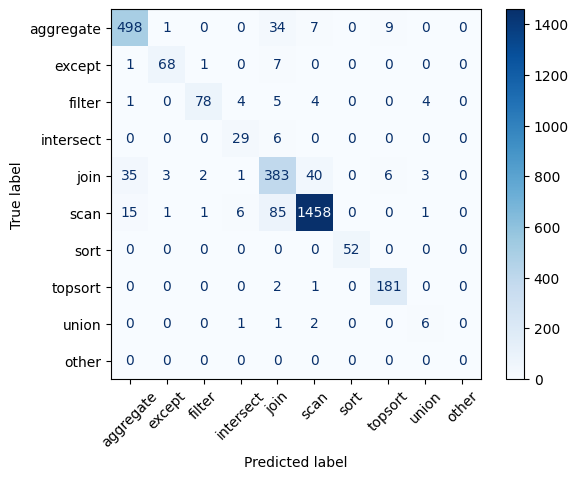

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report

op_correct = 0
sum_similarity = 0
sentences_count = 0

op_to_id = {
    'aggregate': 0,
    'except': 1,
    'filter': 2,
    'intersect': 3,
    'join': 4,
    'scan': 5,
    'sort': 6,
    'topsort': 7,
    'union': 8,
    'other': 9
}
id_to_op = {v: k for k, v in op_to_id.items()}

emb_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

y_pred = []
y_true = []

processor = ProcessorRegistry.get(DATASET_ID)(with_assistant=True)
chat_templates = []
for example in test_dataset:
    chat_templates.append(processor.to_chat_template(example))

output_pattern = re.compile(r"(?P<reasoning><think>.*?</think>)?\s*(?P<answer>.*)", re.DOTALL)

output_json = []
for pred, chat_template in tqdm(zip(predictions, chat_templates), desc="Evaluating", total=len(predictions)):
    if pred is None:
        print("No prediction for chat template:", chat_template)
        continue

    # save prediction vs. gold
    output_json.append({
        "input": [ct for ct in chat_template['messages'] if ct['role'] in ['system', 'user']],
        "pred": pred,
        "gold": chat_template['messages'][-1]['content']
    })

    # process data
    gold = chat_template['messages'][-1]['content']
    if not (gold_match := output_pattern.match(gold)):
        raise ValueError(f"Invalid gold output format: {gold}")
    if not (pred_match := output_pattern.match(pred)):
        print(f"Invalid prediction format:\n\n{pred}\n\n---------------------------")
        continue

    pred_lines = pred_match.group("answer").split("\n")
    gold_lines = gold_match.group("answer").split("\n")

    # operator classification
    pred_op_id = op_to_id.get(pred_lines[0].lower(), op_to_id["other"])
    gold_op_id = op_to_id.get(gold_lines[0].lower(), op_to_id["other"])
    y_pred.append(pred_op_id)
    y_true.append(gold_op_id)

    # sentence similarity
    if pred_op_id == gold_op_id:
        op_correct += 1

        model_sentences = pred_lines[1:]
        label_sentences = gold_lines[1:]

        sentences_count += len(label_sentences)

        if len(model_sentences) != len(label_sentences):
            print("======================")
            print(pred)
            print("----")
            print(gold)
            print("======================")
        else:
            all_sentences = model_sentences + label_sentences
            embeddings = emb_model.encode(all_sentences, show_progress_bar=False)
            similarity_matrix = embeddings @ embeddings.T
            if len(model_sentences) == 0:
                similarity = 0
            elif len(model_sentences) == 1:
                similarity = similarity_matrix[0][1]
            else:
                similarity = max(
                    similarity_matrix[0,2] + similarity_matrix[1,3],
                    similarity_matrix[0,3] + similarity_matrix[1,2]
                ) / 2
            sum_similarity += similarity

print(f"Operator Accuracy: {op_correct / len(test_dataset)}")
print(f"Sentence Similarity (when operator is correct): {sum_similarity / op_correct}")

# Generate a classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Print nicely
df = pd.DataFrame(report).transpose()
df.index = df.index.map(lambda x: id_to_op[int(x)] if x.isdigit() else x)
df['support'] = df['support'].astype(int)
print(df)

cm = confusion_matrix(y_true, y_pred, labels=list(op_to_id.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(op_to_id.keys()))
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45)
plt.show()

In [3]:
import json
with open('output/qpl/decomposer_3_predictions.json', 'w') as f:
    json.dump(output_json, f, indent=2)